<a href="https://colab.research.google.com/github/shanthosh-SP/heroku-demo/blob/main/LSTM_Intraday_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM For Historical Dataset, Chosing Targeting value as Augumented Feature Exponential  Moving Average 

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.80411008599998
GPU (s):
0.040417181999998775
GPU speedup over CPU: 94x


In [5]:
import pandas as pd
df=pd.read_excel('/content/history.xlsx')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily lag,Daily return,SMA(10 interval),EMA,DailyVariationPercentage,Multiplyer
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800,0.000000,0.000000,0.097222,0.097222,8.928021,NaN
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000,0.097222,-0.034481,0.098958,0.097223,3.448071,0.000226
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200,0.100694,-0.016958,0.100116,0.097224,1.695774,NaN
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400,0.102431,0.026095,0.100043,0.097225,-2.609539,NaN
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400,0.099826,0.017698,0.099653,0.097225,-1.769803,NaN


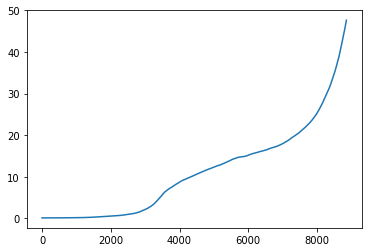

In [6]:
##prediction on close
df1=df.reset_index()['EMA']
df1.shape

import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

df1.shape

##Spliting train test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print(training_size)
print(test_size)
print(df1.shape)

5757
3100
(8857, 1)


In [8]:
##convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset,time_step=1):
	dataX,dataY=[],[]
	for i in range(len(dataset)-time_step-1):
		a=dataset[i:(i+time_step),0]
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return numpy.array(dataX),numpy.array(dataY)

##reshape into X=t,t+1,t+2,t+3 and t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)
 

#reshape input to be [samples,time steps,features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

##create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
89/89 [==============================] - 14s 93ms/step - loss: 9.5547e-04 - val_loss: 4.7836e-04
Epoch 2/100
89/89 [==============================] - 7s 80ms/step - loss: 1.0130e-06 - val_loss: 0.0016
Epoch 3/100
89/89 [==================

In [9]:
import tensorflow as tf

tf.__version__

##Lets Do the Prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##transform to orginal form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [10]:
##calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

6.984311817138064
23.708095808458733


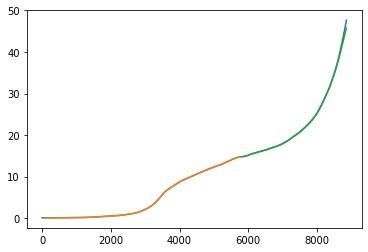

In [11]:
##Plotting
##shift train predictions for plotting
look_back=100
trainPredictPlot=numpy.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

##shift test predictions for plotting
testPredictPlot =numpy.empty_like(df1)
testPredictPlot[:,:]=numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

##plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## The Targeted value of Historical dataset is Closing price

In [12]:
import pandas as pd
df=pd.read_excel('/content/history.xlsx')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily lag,Daily return,SMA(10 interval),EMA,DailyVariationPercentage,Multiplyer
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800,0.000000,0.000000,0.097222,0.097222,8.928021,NaN
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000,0.097222,-0.034481,0.098958,0.097223,3.448071,0.000226
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200,0.100694,-0.016958,0.100116,0.097224,1.695774,NaN
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400,0.102431,0.026095,0.100043,0.097225,-2.609539,NaN
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400,0.099826,0.017698,0.099653,0.097225,-1.769803,NaN


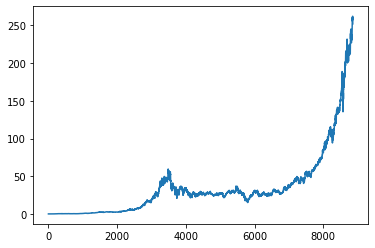

In [13]:
##prediction on close
df1=df.reset_index()["Close"]
df1.shape

import matplotlib.pyplot as plt
plt.plot(df1)


In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

df1.shape

##Spliting train test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print(training_size)
print(test_size)
print(df1.shape)

5757
3100
(8857, 1)


In [15]:
##convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset,time_step=1):
	dataX,dataY=[],[]
	for i in range(len(dataset)-time_step-1):
		a=dataset[i:(i+time_step),0]
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return numpy.array(dataX),numpy.array(dataY)

##reshape into X=t,t+1,t+2,t+3 and t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)
 

#reshape input to be [samples,time steps,features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

##create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
89/89 [==============================] - 13s 95ms/step - loss: 3.1080e-04 - val_loss: 0.0020
Epoch 2/100
89/89 [==============================] - 7s 80ms/step - loss: 3.3332e-05 - val_loss: 0.0027
Epoch 3/100
89/89 [====================

In [16]:
import tensorflow as tf

tf.__version__

##Lets Do the Prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##transform to orginal form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [17]:
##calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

21.76162169109161
87.07783434679874


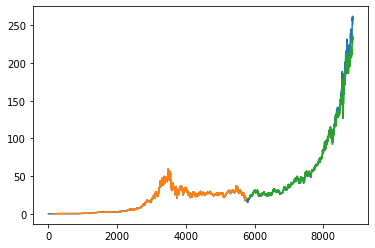

In [18]:
##Plotting
##shift train predictions for plotting
look_back=100
trainPredictPlot=numpy.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

##shift test predictions for plotting
testPredictPlot =numpy.empty_like(df1)
testPredictPlot[:,:]=numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

##plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Considering the Monthly dataset, Selecting the Targeting value as Augumeted feature Simple moving Average

In [35]:
import pandas as pd
df=pd.read_excel('/content/monthly.xlsx')
df.head()
df.tail()

,Type,Date,Time,open,high,low,close,SMA,EMA,DailyLag,DailyReturn,Month,DailyVariationPercentage,Unnamed: 13
22728,NIFTY,20210331,15:27:00,14687.35,14694.35,14686.30,14690.60,14687.97,14677.354347,14687.65,-0.000201,March,0.054797,NaN
22729,NIFTY,20210331,15:28:00,14690.90,14690.90,14686.05,14689.30,14688.09,14677.355395,14690.60,0.000088,March,0.033017,NaN
22730,NIFTY,20210331,15:29:00,14690.30,14694.10,14688.55,14691.30,14689.32,14677.356618,14689.30,-0.000136,March,0.037777,NaN
22731,NIFTY,20210331,15:30:00,14689.85,14693.55,14689.45,14693.05,14690.38,14677.357994,14691.30,-0.000119,March,0.027904,NaN
22732,NIFTY,20210331,15:31:00,14690.70,14690.70,14690.70,14690.70,14690.99,14677.359164,14693.05,0.000160,March,0.000000,NaN


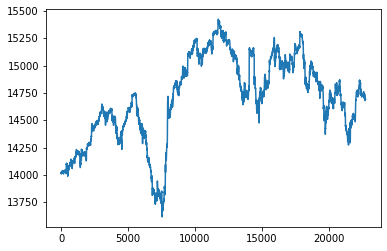

In [20]:
##prediction on close
df1=df.reset_index()['SMA']
df1.shape

import matplotlib.pyplot as plt
plt.plot(df1)


In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

df1.shape

##Spliting train test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print(training_size)
print(test_size)

14776
7957


In [22]:
##convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset,time_step=1):
	dataX,dataY=[],[]
	for i in range(len(dataset)-time_step-1):
		a=dataset[i:(i+time_step),0]
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return numpy.array(dataX),numpy.array(dataY)

##reshape into X=t,t+1,t+2,t+3 and t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)
 

#reshape input to be [samples,time steps,features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

##create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
230/230 [==============================] - 24s 85ms/step - loss: 0.0055 - val_loss: 2.0781e-04
Epoch 2/100
230/230 [==============================] - 18s 79ms/step - loss: 1.8650e-04 - val_loss: 1.9649e-04
Epoch 3/100
230/230 [=========

In [23]:
import tensorflow as tf

tf.__version__

##Lets Do the Prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##transform to orginal form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [36]:
##calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

14636.447010653514
14840.413638772638


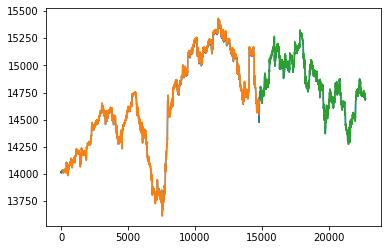

In [25]:
##Plotting
##shift train predictions for plotting
look_back=100
trainPredictPlot=numpy.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

##shift test predictions for plotting
testPredictPlot =numpy.empty_like(df1)
testPredictPlot[:,:]=numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

##plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Considering the Targeted Feature as Closing price of Monthly dataset

In [26]:
import pandas as pd
df=pd.read_excel('/content/monthly.xlsx')
df.head()

,Type,Date,Time,open,high,low,close,SMA,EMA,DailyLag,DailyReturn,Month,DailyVariationPercentage,Unnamed: 13
0,NIFTY,20210101,09:16:00,13997.90,14020.85,13991.35,14013.15,14013.15,14013.150000,0.00,0.000000,Jan,0.210517,0.000088
1,NIFTY,20210101,09:17:00,14014.85,14018.55,14008.15,14009.05,14009.05,14009.050000,14013.15,0.000293,Jan,0.074238,NaN
2,NIFTY,20210101,09:18:00,14008.05,14013.10,14005.05,14012.70,14012.70,14012.700000,14009.05,-0.000260,Jan,0.057448,NaN
3,NIFTY,20210101,09:19:00,14013.65,14019.10,14013.65,14016.20,14016.20,14016.200000,14012.70,-0.000250,Jan,0.038884,NaN
4,NIFTY,20210101,09:20:00,14015.45,14017.80,14011.95,14015.45,14013.31,14013.310188,14016.20,0.000054,Jan,0.041740,NaN


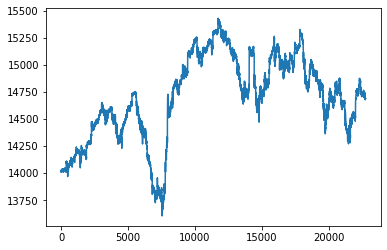

In [27]:
##prediction on close
df1=df.reset_index()['close']
df1.shape

import matplotlib.pyplot as plt
plt.plot(df1)


In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

df1.shape

##Spliting train test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [29]:
##convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset,time_step=1):
	dataX,dataY=[],[]
	for i in range(len(dataset)-time_step-1):
		a=dataset[i:(i+time_step),0]
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return numpy.array(dataX),numpy.array(dataY)

##reshape into X=t,t+1,t+2,t+3 and t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)
 

#reshape input to be [samples,time steps,features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

##create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
230/230 [==============================] - 23s 84ms/step - loss: 0.0089 - val_loss: 2.2771e-04
Epoch 2/100
230/230 [==============================] - 18s 80ms/step - loss: 2.0547e-04 - val_loss: 2.0379e-04
Epoch 3/100
230/230 [=========

In [ ]:
import tensorflow as tf

tf.__version__

##Lets Do the Prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##transform to orginal form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [37]:
##calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

14636.447010653514
14840.413638772638


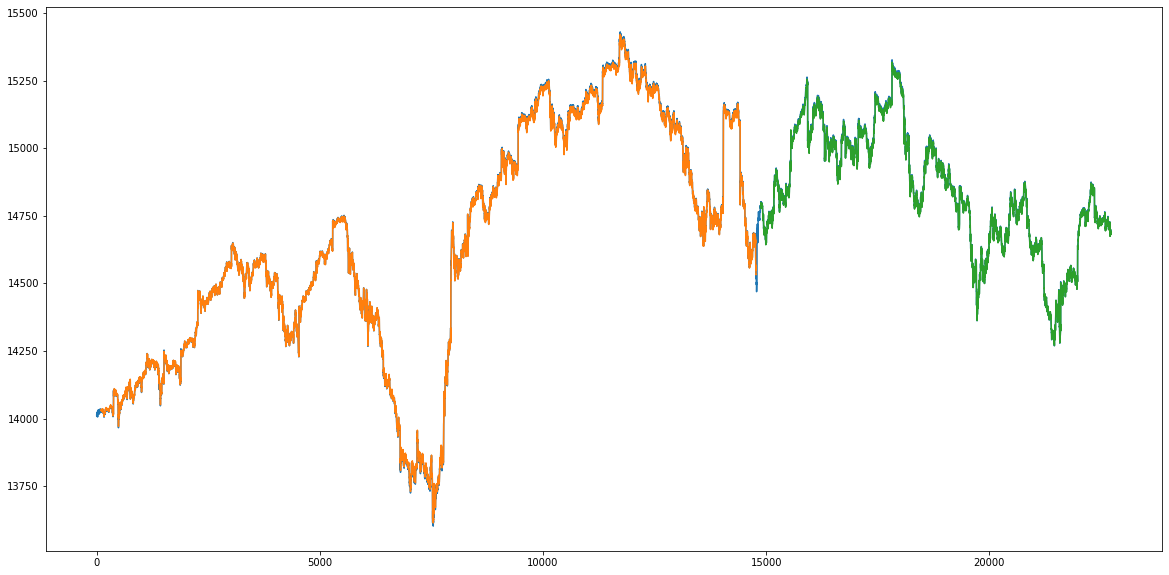

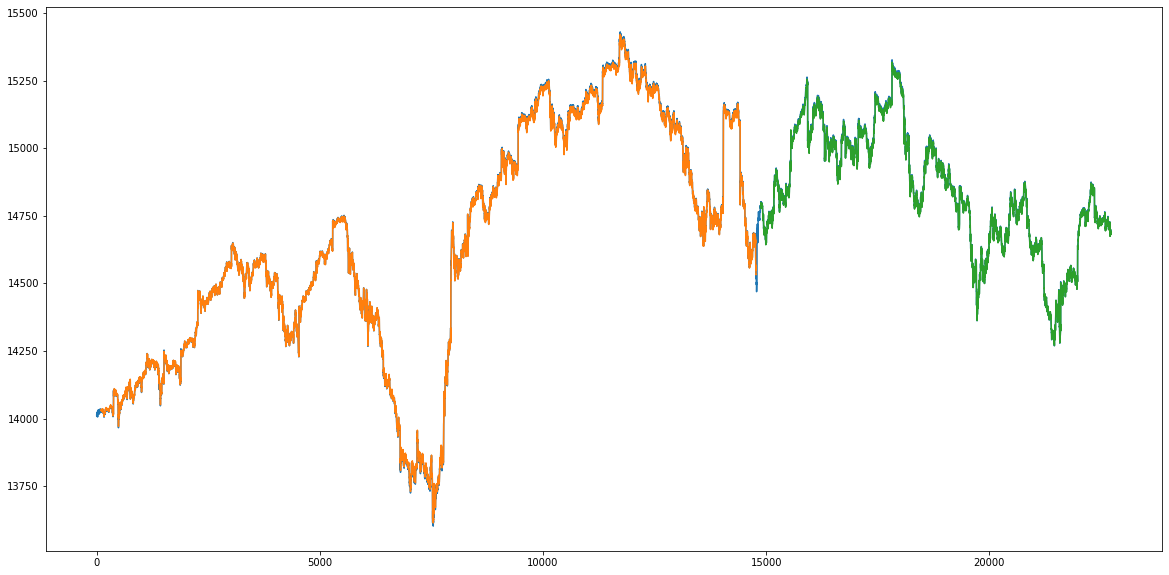

In [32]:
##Plotting
##shift train predictions for plotting
look_back=100
trainPredictPlot=numpy.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

##shift test predictions for plotting
testPredictPlot =numpy.empty_like(df1)
testPredictPlot[:,:]=numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

##plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()